# Content

1. Read in <strike>two</strike> one file<strike>s</strike> per read_csv() separately
1. <strike>Merge two datasources /for lines of code(?) -> would be optional</strike>
1. Calculate ownership

In [2]:
import pandas as pd

changes = pd.read_csv("git_log_prepared.log")
changes.head()

,author,filename,additions,deletions
0,Antoine Rey,src/test/java/petclinic/web/CrashControllerTes...,4.0,5.0
1,Antoine Rey,src/test/java/petclinic/web/OwnerControllerTes...,25.0,7.0
2,Antoine Rey,src/test/java/petclinic/web/PetControllerTests...,21.0,9.0
3,Antoine Rey,src/test/java/petclinic/web/VetControllerTests...,23.0,3.0
4,Antoine Rey,src/test/java/petclinic/web/VisitControllerTes...,10.0,6.0


In [3]:
top5_changes = pd.DataFrame(changes.filename.value_counts()).head()
top5_changes

,filename
src/main/java/petclinic/repository/jdbc/JdbcOwnerRepositoryImpl.java,23
src/main/java/petclinic/web/OwnerController.java,19
src/main/java/petclinic/repository/jdbc/JdbcVetRepositoryImpl.java,18
src/main/java/petclinic/web/PetController.java,18
src/main/java/petclinic/repository/jdbc/JdbcVisitRepositoryImpl.java,16


In [4]:
import glob

file_list = glob.glob("../../../buschmais-spring-petclinic/src/**/*.java", recursive=True)
file_list

lines_of_code = []


for filename in file_list:
    lines = 0
    indent = 0
    with open(filename) as f:
        for line in f.readlines():
            line = line.replace("\t", " ")
            # BUG: Just count first whitespaces, not all in line
            indent = indent + line.count(" ")
            lines = lines + 1
    lines_of_code.append([filename, lines, indent])
    
lines_df = pd.DataFrame(lines_of_code, columns=["file", "lines", "indent"])
lines_df['file'] = lines_df.file.str.replace("\\", "/").str.replace("../../../buschmais-spring-petclinic/", "")
lines_df = lines_df.sort_values(by="lines", ascending=False)
lines_df['file'] = lines_df.file.str.replace("org/springframework/samples/", "")

lines_df.head()

,file,lines,indent
47,src/test/java/petclinic/service/AbstractClinic...,204,1283
52,src/test/java/petclinic/web/OwnerControllerTes...,185,1301
16,src/main/java/petclinic/repository/jdbc/JdbcOw...,158,1177
3,src/main/java/petclinic/model/Owner.java,153,938
39,src/main/java/petclinic/web/OwnerController.java,138,925


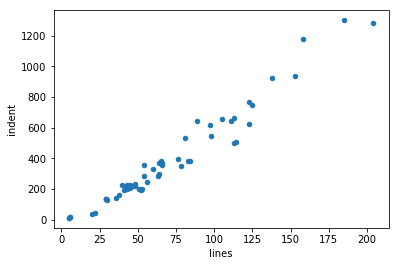

In [5]:
%matplotlib inline
lines_df.plot.scatter('lines', 'indent')

In [6]:
changes.head()

,author,filename,additions,deletions
0,Antoine Rey,src/test/java/petclinic/web/CrashControllerTes...,4.0,5.0
1,Antoine Rey,src/test/java/petclinic/web/OwnerControllerTes...,25.0,7.0
2,Antoine Rey,src/test/java/petclinic/web/PetControllerTests...,21.0,9.0
3,Antoine Rey,src/test/java/petclinic/web/VetControllerTests...,23.0,3.0
4,Antoine Rey,src/test/java/petclinic/web/VisitControllerTes...,10.0,6.0


In [7]:
changes['lines'] = changes.additions - changes.deletions
changes.groupby("filename").sum().sort_values(by='lines', ascending=False).head()

,additions,deletions,lines
filename,,,
src/test/java/petclinic/service/AbstractClinicServiceTests.java,388.0,184.0,204.0
src/test/java/petclinic/web/OwnerControllerTests.java,192.0,7.0,185.0
src/main/java/petclinic/repository/jdbc/JdbcOwnerRepositoryImpl.java,388.0,230.0,158.0
src/main/java/petclinic/model/Owner.java,290.0,137.0,153.0
src/main/java/petclinic/web/OwnerController.java,311.0,173.0,138.0


In [8]:
result = pd.merge(lines_df, changes, left_on='file', right_on="filename")
result.head()

,file,lines_x,indent,author,filename,additions,deletions,lines_y
0,src/test/java/petclinic/service/AbstractClinic...,204,1283,Attilio,src/test/java/petclinic/service/AbstractClinic...,10.0,0.0,10.0
1,src/test/java/petclinic/service/AbstractClinic...,204,1283,Faisal Hameed,src/test/java/petclinic/service/AbstractClinic...,1.0,1.0,0.0
2,src/test/java/petclinic/service/AbstractClinic...,204,1283,Antoine Rey,src/test/java/petclinic/service/AbstractClinic...,2.0,1.0,1.0
3,src/test/java/petclinic/service/AbstractClinic...,204,1283,Antoine Rey,src/test/java/petclinic/service/AbstractClinic...,86.0,86.0,0.0
4,src/test/java/petclinic/service/AbstractClinic...,204,1283,Antoine Rey,src/test/java/petclinic/service/AbstractClinic...,2.0,0.0,2.0


In [13]:
def aggregate_additions(group):
    df = group.groupby(['author'])[['additions']].count()
    df['all_additions'] = group['additions'].count()
    df['ownership'] = df['additions'] / df['all_additions']
    return df

ownerships = changes.groupby('filename').apply(aggregate_additions)
ownerships.groupby('filename')[['ownership']].max()

,ownership
filename,
org.springframework.samples.petclinic/src/main/java/petclinic/HomeController.java,0.750000
org.springframework.samples.petclinic/src/main/java/petclinic/appointments/Appointment.java,0.500000
org.springframework.samples.petclinic/src/main/java/petclinic/appointments/AppointmentBook.java,0.500000
org.springframework.samples.petclinic/src/main/java/petclinic/appointments/AppointmentForm.java,0.500000
org.springframework.samples.petclinic/src/main/java/petclinic/appointments/Appointments.java,0.500000
org.springframework.samples.petclinic/src/main/java/petclinic/appointments/AppointmentsController.java,0.666667
org.springframework.samples.petclinic/src/main/java/petclinic/appointments/StubAppointmentBook.java,0.500000
org.springframework.samples.petclinic/src/main/java/petclinic/owner/Owner.java,1.000000
org.springframework.samples.petclinic/src/main/java/petclinic/owner/OwnerController.java,1.000000


In [19]:
ownerships.loc["org.springframework.samples.petclinic/src/main/java/petclinic/pet/PetRepository.java"]

,additions,all_additions,ownership
author,,,
Keith Donald,2,2,1.0


In [16]:
ownerships.loc["org.springframework.samples.petclinic/src/main/java/petclinic/owner/OwnerController.java"]

,additions,all_additions,ownership
author,,,
Keith Donald,2,2,1.0


In [9]:
def aggregate_additions(group):
    df = group.groupby(['author'])[['additions']].sum()
    df['all_additions'] = group['additions'].sum()
    df['ownership'] = df['additions'] / df['all_additions']
    return df

changes.groupby('filename').apply(aggregate_additions)

additions  \
filename                                           author                      
org.springframework.samples.petclinic/src/main/... Keith Donald         17.0   
                                                   Michael Isvy          0.0   
org.springframework.samples.petclinic/src/main/... Keith Donald         37.0   
                                                   Michael Isvy          0.0   
org.springframework.samples.petclinic/src/main/... Keith Donald         13.0   
                                                   Michael Isvy          0.0   
org.springframework.samples.petclinic/src/main/... Keith Donald         67.0   
                                                   Michael Isvy          0.0   
org.springframework.samples.petclinic/src/main/... Keith Donald         15.0   
                                                   Michael Isvy          0.0   
org.springframework.samples.petclinic/src/main/... Keith Donald         44.0   
                                                   Michael Isvy          0.0   
org.springframework.samples.petclinic/src/main/... Keith Donald         23.0   
                                                   Michael Isvy          0.0   
org.springframework.samples.petclinic/src/main/... Keith Donald         26.0   
org.springframework.samples.petclinic/src/main/... Keith Donald         36.0   
org.springframework.samples.petclinic/src/main/... Keith Donald         13.0   
org.springframework.samples.petclinic/src/main/... Keith Donald         45.0   
org.springframework.samples.petclinic/src/main/... Keith Donald         21.0   
org.springframework.samples.petclinic/src/main/... Keith Donald         78.0   
                                                   Michael Isvy          0.0   
org.springframework.samples.petclinic/src/main/... Keith Donald         45.0   
                                                   Michael Isvy          0.0   
org.springframework.samples.petclinic/src/main/... Keith Donald         14.0   
                                                   Michael Isvy          0.0   
org.springframework.samples.petclinic/src/main/... Keith Donald         15.0   
                                                   Michael Isvy          0.0   
org.springframework.samples.petclinic/src/main/... Keith Donald         50.0   
                                                   Michael Isvy          0.0   
org.springframework.samples.petclinic/src/main/... Keith Donald         24.0   
...                                                                      ...   
src/test/java/petclinic/service/ClinicServiceJd... Michael Isvy         37.0   
src/test/java/petclinic/service/ClinicServiceJp... Antoine Rey           3.0   
                                                   Michael Isvy         30.0   
src/test/java/petclinic/service/ClinicServiceSp... Antoine Rey           4.0   
                                                   Michael Isvy         20.0   
src/test/java/petclinic/springdatajpa/JpaOwnerR... Michael Isvy         36.0   
src/test/java/petclinic/springdatajpa/JpaPetRep... Michael Isvy         30.0   
src/test/java/petclinic/springdatajpa/JpaVetRep... Michael Isvy         30.0   
src/test/java/petclinic/springdatajpa/JpaVisitR... Michael Isvy         30.0   
src/test/java/petclinic/springdatajpa/SpringDat... Michael Isvy         21.0   
src/test/java/petclinic/web/CrashControllerTest... Antoine Rey           4.0   
                                                   Colin But            53.0   
src/test/java/petclinic/web/OwnerControllerTest... Antoine Rey          25.0   
                                                   Colin But           167.0   
src/test/java/petclinic/web/PetControllerTests.... Antoine Rey          21.0   
                                                   Colin But           113.0   
src/test/java/petclinic/web/PetTypeFormatterTes... Colin But            76.0   
src/test/java/petclinic/web/VetControllerTest.java Michael Isvy    

Wegen Datenschutz reicht es ja, nur die "Stärke" der Wissenskonzentration zu visualisieren